In [1]:
library(Seurat)
library(tidyverse)
library(ggplot2)
library(ggrepel)
library(ggbeeswarm)
library(patchwork)
library(miloR)
options(ggrepel.max.overlaps = Inf)


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: edgeR

Loading required package: limma



In [2]:
source('milo_cellbender.R')

In [3]:
obj_neuron = qs::qread('_targets/objects/exp_labelled_neuron') %>%
    set_labels_to_class %>%
    set_batch_to_lane %>%
    prep_obj_for_milo_cb_v01

In [4]:
obj_neuron

An object of class Seurat 
29128 features across 104587 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



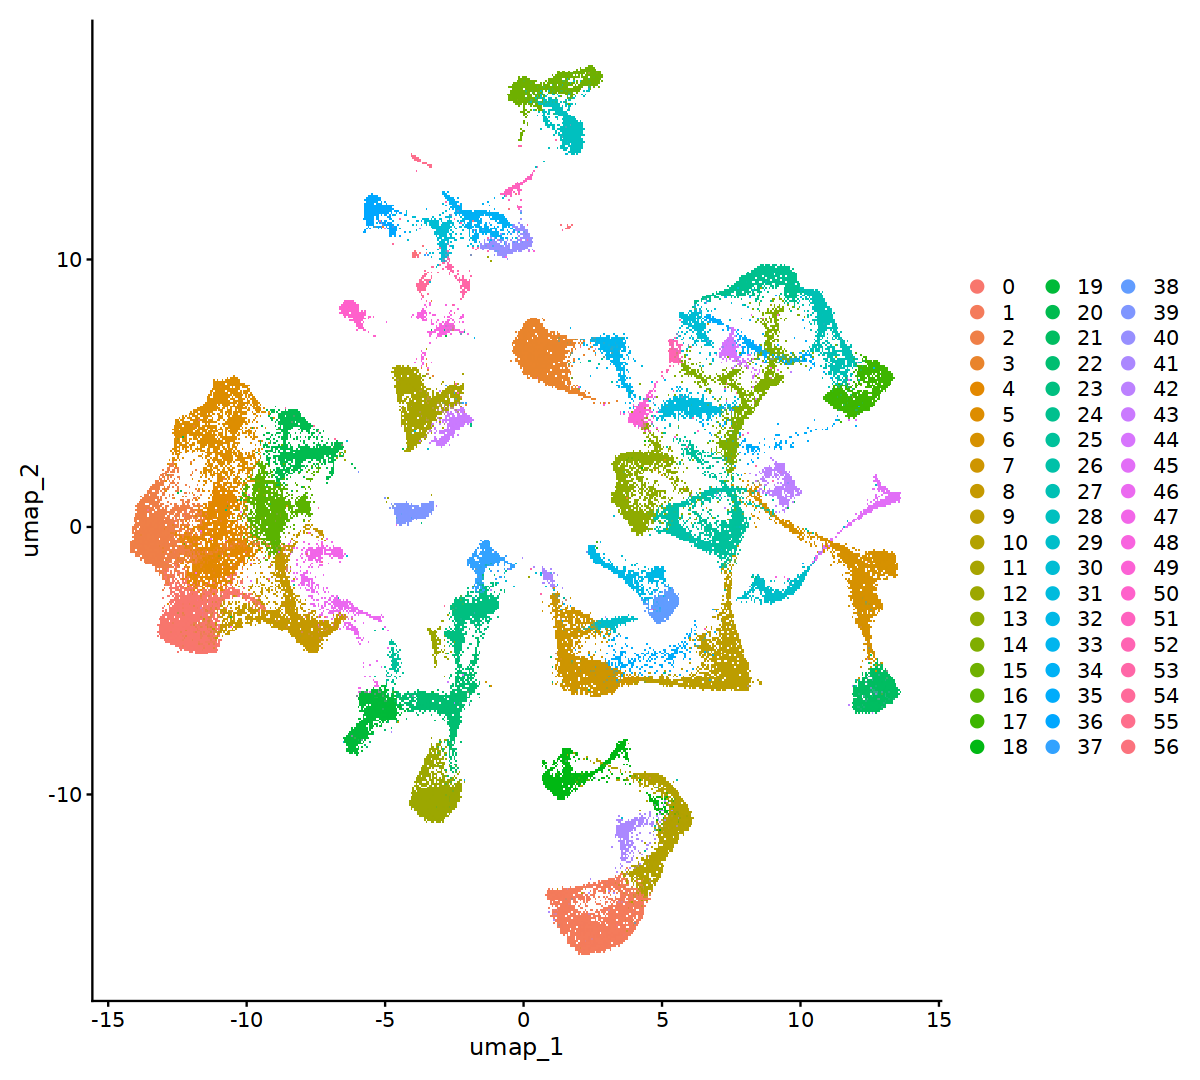

In [5]:
options(repr.plot.width=10, repr.plot.height=9)
DimPlot(obj_neuron)

In [6]:
obj_other = qs::qread('_targets/objects/exp_labelled_other') %>%
    set_labels_to_class %>%
    set_batch_to_lane %>%
    prep_obj_for_milo_cb_v01
obj_other

An object of class Seurat 
25033 features across 29782 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [7]:
obj_milo = qs::qread('_targets/objects/milo_Day5.other')
obj_milo

class: Milo 
dim: 2000 15099 
metadata(0):
assays(1): logcounts
rownames(2000): Gm13187 Frmd4a ... Samd5 Adamts9
rowData names(0):
colnames(15099): SI-TT-A11_AAACGAAAGGTTCTTG SI-TT-A11_AAACGCTAGTGCTAGG
  ... SI-TT-G11_TTTGGAGCATGCAGCC SI-TT-G11_TTTGGAGTCGGACTGC
colData names(42): orig.ident nCount_RNA ... group ident
reducedDimNames(2): PCA UMAP
mainExpName: integrated
altExpNames(0):
nhoods dimensions(2): 15099 855
nhoodCounts dimensions(2): 855 18
nhoodDistances dimension(1): 855
graph names(1): graph
nhoodIndex names(1): 855
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(1): nhoodGraph
nhoodAdjacency dimension(2): 855 855

In [8]:
obj_milo = makeNhoods(obj_milo, prop = 0.5, k = 40, d=30, refined = TRUE)
obj_milo

Checking valid object

Running refined sampling with reduced_dim



class: Milo 
dim: 2000 15099 
metadata(0):
assays(1): logcounts
rownames(2000): Gm13187 Frmd4a ... Samd5 Adamts9
rowData names(0):
colnames(15099): SI-TT-A11_AAACGAAAGGTTCTTG SI-TT-A11_AAACGCTAGTGCTAGG
  ... SI-TT-G11_TTTGGAGCATGCAGCC SI-TT-G11_TTTGGAGTCGGACTGC
colData names(42): orig.ident nCount_RNA ... group ident
reducedDimNames(2): PCA UMAP
mainExpName: integrated
altExpNames(0):
nhoods dimensions(2): 15099 1881
nhoodCounts dimensions(2): 855 18
nhoodDistances dimension(1): 855
graph names(1): graph
nhoodIndex names(1): 1881
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(1): nhoodGraph
nhoodAdjacency dimension(2): 855 855

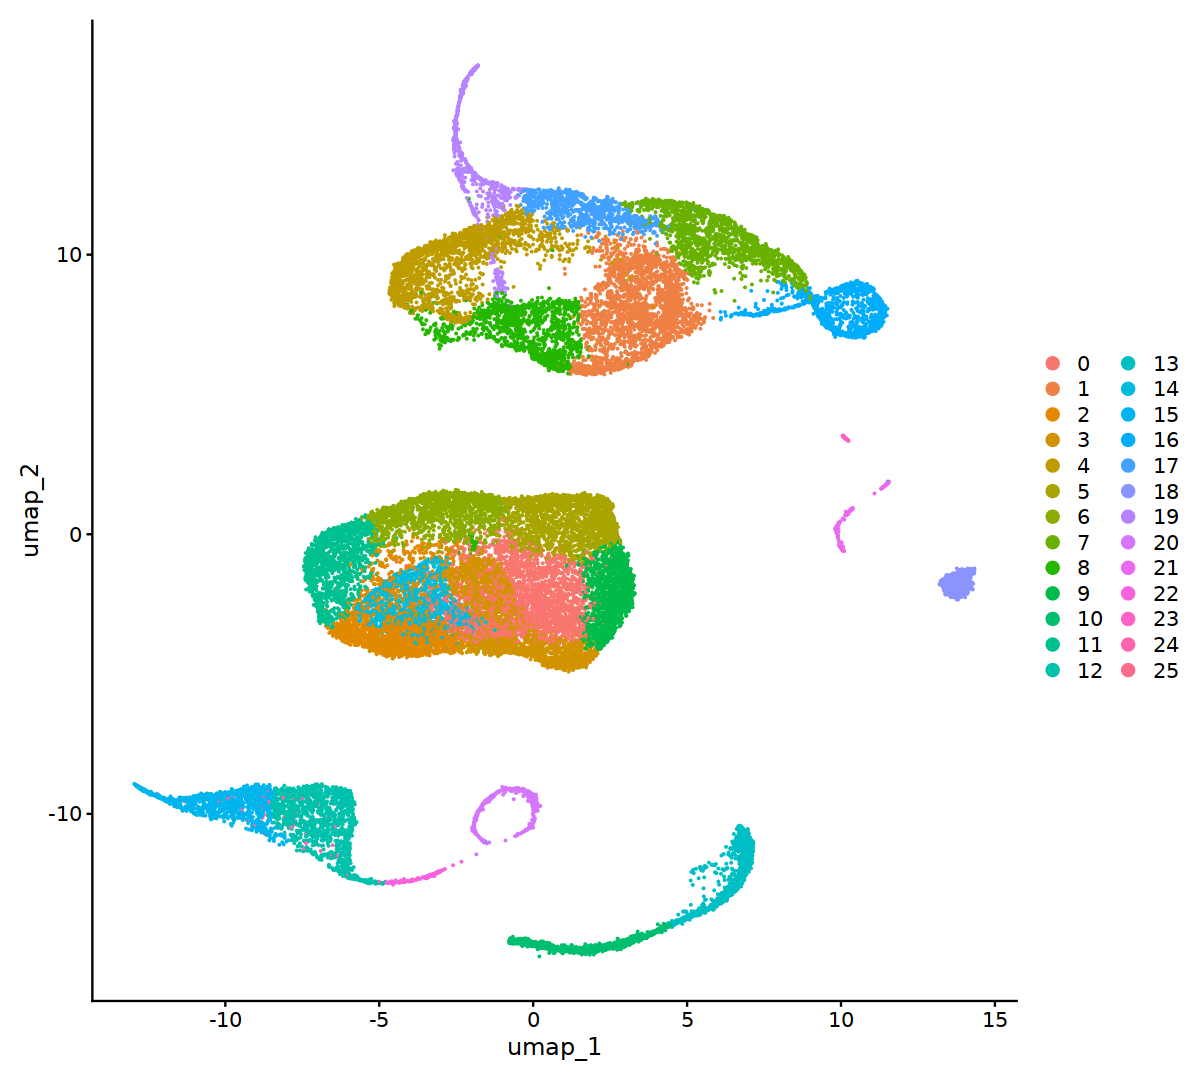

In [9]:
options(repr.plot.width=10, repr.plot.height=9)
DimPlot(obj_other)

In [10]:
labels_classes_tib = (obj_other@meta.data %>% select(labels) %>% mutate(class = 'other') %>% tibble %>% distinct(labels, class)) %>%
bind_rows(obj_neuron@meta.data %>% select(labels) %>% mutate(class = 'neuron') %>% tibble %>% distinct(labels, class)) %>%
mutate(labels = str_replace(labels, fixed('-'), '__'))
# mutate(class = case_when(labels == 'neuron' ~ 'neuron',
#                          labels == 'other' ~ 'other'))

labels_classes_tib

labels,class
<chr>,<chr>
other,other
neuron,neuron


In [11]:
umap_coords_neuron = obj_neuron %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_neuron %>% head
umap_coords_neuron %>% dim

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAAGGTGGTTG,1.060039,-9.89935829
2,SI-TT-A11_AAACCCACATACAGCT,4.324369,1.16208909
3,SI-TT-A11_AAACCCACATGAGGGT,4.696438,-3.14927985
4,SI-TT-A11_AAACCCAGTACGTTCA,1.344125,-13.86531212
5,SI-TT-A11_AAACCCATCCAAGCAT,-5.445605,12.35118530
6,SI-TT-A11_AAACCCATCCCATAAG,-9.186716,0.09222025


[1] 104587      3

In [12]:
umap_coords_other = obj_other %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_other %>% head
umap_coords_other %>% dim

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAGTATCGGTT,-3.457507,10.322045
2,SI-TT-A11_AAACGAAAGGTTCTTG,5.005185,-13.727981
3,SI-TT-A11_AAACGAACAAGGAGTC,-3.099344,-3.947226
4,SI-TT-A11_AAACGAACAGCCTTCT,-2.956816,-3.160569
5,SI-TT-A11_AAACGCTAGTGCTAGG,-2.045796,7.196627
6,SI-TT-A11_AAAGGATTCAACCCGG,2.649539,10.880517


[1] 29782     3

In [13]:
ambiguous_cells = intersect(umap_coords_neuron %>% pull(cell_barcode), umap_coords_other %>% pull(cell_barcode))
ambiguous_cells %>% length

[1] 0

In [14]:
umap_coords_neuron = umap_coords_neuron %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords_other = umap_coords_other %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords = bind_rows(umap_coords_neuron, umap_coords_other)
umap_coords %>% dim

[1] 134369      3

In [15]:
# da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_all.obob5v5__v__all.obobBL6')
da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_Day5.obob5v5__v__Day5.obobBL6d5') %>%
filter(labels %in% c('neuron', 'other'))
# column_to_rownames('hash.mcl.ID')

dim(da_results_restored)
da_results_restored %>% head

[1] 3685   18

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,comparison,restored,exact_grouping,restored_grouping,fgf1_grouping,bl6_grouping,hash.mcl.ID,n_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,3.016999,8.331943,29.25532,2.160218e-05,0.06113417,2381,0.06471961,pos,neuron,1,Day5.obob5v5__v__Day5.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-F10_ACCAAACGTCGATTAC,77
2,-1.868546,9.409548,20.01991,2.009035e-04,0.27046937,34,0.24549030,none,neuron,1,Day5.obob5v5__v__Day5.obobBL6d5,FALSE,none,none,none,none,SI-TT-D11_ACACGCGAGGTTGGAC,190
3,3.396575,8.045479,17.46648,4.092979e-04,0.27046937,71,0.24549030,none,neuron,1,Day5.obob5v5__v__Day5.obobBL6d5,FALSE,none,none,none,none,SI-TT-G10_AACGAAAGTCACAGTT,56
4,1.970190,8.874138,11.70623,2.515516e-03,0.27730791,83,0.24549030,none,neuron,1,Day5.obob5v5__v__Day5.obobBL6d5,FALSE,none,none,none,none,SI-TT-F10_ATCGATGCAGCGTGCT,127
5,1.942847,9.442335,13.82117,1.242439e-03,0.27046937,93,0.24549030,none,neuron,1,Day5.obob5v5__v__Day5.obobBL6d5,FALSE,none,none,none,none,SI-TT-G10_TACCTCGTCCACGGGT,206
6,1.884718,9.296982,10.96255,3.264256e-03,0.27730791,98,0.24549030,none,neuron,1,Day5.obob5v5__v__Day5.obobBL6d5,FALSE,none,none,none,none,SI-TT-G10_GTATTTCGTTGCTAGT,185


In [16]:
da_results_restored %>% distinct(labels) 

labels
<chr>
neuron
other


In [17]:
# da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_all.obobBL6') %>%
da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_Day5.obobBL6d5') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y) %>%
mutate(polarity = case_when(polarity == 'none' ~ 'none',
                            polarity == 'pos' ~ 'neg',
                            polarity == 'neg' ~ 'pos')) %>%
mutate(logFC = -logFC) %>%
filter(labels %in% c('neuron', 'other'))


dim(da_results_bl6)
da_results_bl6 %>% head

[1] 3685   12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,6.918666,8.906308,120.50281,2.981706e-10,8.438229e-07,2603,6.776841e-07,none,neuron,1,122,SI-TT-H10_TCACTATGTACTCCGG
2,6.785299,8.659537,95.53348,2.405322e-09,2.277156e-06,1008,1.924473e-06,none,neuron,1,98,SI-TT-F11_AATGACCGTAGTGTGG
3,6.982032,8.953897,95.49473,2.413947e-09,2.277156e-06,1399,1.924473e-06,none,neuron,1,127,SI-TT-H10_CTGGCAGTCCGATAGT
4,5.517441,8.893444,90.07895,4.029543e-09,2.487674e-06,1282,2.137802e-06,none,neuron,1,120,SI-TT-G10_TCCTAATCATGCAGGA
5,5.694697,8.782148,89.18640,4.395184e-09,2.487674e-06,2341,2.137802e-06,none,neuron,1,110,SI-TT-G10_TCGAAGTGTCCAACGC
6,5.935565,8.966793,76.65999,1.612731e-08,7.606713e-06,2046,6.450493e-06,none,neuron,1,129,SI-TT-F10_TGTACAGCAAGGTCAG


In [18]:
da_results_fgf1 = qs::qread('_targets/objects/combined_da_results_idx_Day5.obob5v5') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y)  %>%
filter(labels %in% c('neuron', 'other'))


dim(da_results_fgf1)
da_results_fgf1 %>% head

[1] 3685   12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,3.016999,8.331943,29.25532,2.160218e-05,0.06113417,2381,0.06471961,none,neuron,1,77,SI-TT-F10_ACCAAACGTCGATTAC
2,-1.868546,9.409548,20.01991,2.009035e-04,0.27046937,34,0.24549030,none,neuron,1,190,SI-TT-D11_ACACGCGAGGTTGGAC
3,3.396575,8.045479,17.46648,4.092979e-04,0.27046937,71,0.24549030,none,neuron,1,56,SI-TT-G10_AACGAAAGTCACAGTT
4,1.970190,8.874138,11.70623,2.515516e-03,0.27730791,83,0.24549030,none,neuron,1,127,SI-TT-F10_ATCGATGCAGCGTGCT
5,1.942847,9.442335,13.82117,1.242439e-03,0.27046937,93,0.24549030,none,neuron,1,206,SI-TT-G10_TACCTCGTCCACGGGT
6,1.884718,9.296982,10.96255,3.264256e-03,0.27730791,98,0.24549030,none,neuron,1,185,SI-TT-G10_GTATTTCGTTGCTAGT


In [19]:
da_results_2 = full_join(da_results_fgf1, da_results_bl6, by=c('Nhood', 'labels'), suffix = c('_fgf1', '_bl6'))
da_results_2 %>% head

,logFC_fgf1,logCPM_fgf1,F_fgf1,PValue_fgf1,FDR_fgf1,Nhood,SpatialFDR_fgf1,polarity_fgf1,labels,labels_fraction_fgf1,⋯,logFC_bl6,logCPM_bl6,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,hash.mcl.ID_bl6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,3.016999,8.331943,29.25532,2.160218e-05,0.06113417,2381,0.06471961,none,neuron,1,⋯,2.8923660,8.331943,21.0409328,0.0001531577,0.003976478,0.003433336,none,1,77,SI-TT-F10_ACCAAACGTCGATTAC
2,-1.868546,9.409548,20.01991,2.009035e-04,0.27046937,34,0.24549030,none,neuron,1,⋯,-0.3775586,9.409548,0.5772793,0.4556723095,0.801906214,0.797542710,none,1,190,SI-TT-D11_ACACGCGAGGTTGGAC
3,3.396575,8.045479,17.46648,4.092979e-04,0.27046937,71,0.24549030,none,neuron,1,⋯,2.5115663,8.045479,6.2989683,0.0201785453,0.223013296,0.208063638,none,1,56,SI-TT-G10_AACGAAAGTCACAGTT
4,1.970190,8.874138,11.70623,2.515516e-03,0.27730791,83,0.24549030,none,neuron,1,⋯,1.6946113,8.874138,6.1254341,0.0217600526,0.235942333,0.220118649,none,1,127,SI-TT-F10_ATCGATGCAGCGTGCT
5,1.942847,9.442335,13.82117,1.242439e-03,0.27046937,93,0.24549030,none,neuron,1,⋯,1.6724816,9.442335,7.4797063,0.0122800442,0.161585398,0.148503017,none,1,206,SI-TT-G10_TACCTCGTCCACGGGT
6,1.884718,9.296982,10.96255,3.264256e-03,0.27730791,98,0.24549030,none,neuron,1,⋯,1.0331300,9.296982,2.2275396,0.1501704518,0.549230589,0.532573136,none,1,185,SI-TT-G10_GTATTTCGTTGCTAGT


In [20]:
da_results = da_results_restored %>% full_join(da_results_2, by=c('Nhood', 'labels')) %>%
mutate(exact_grouping = case_when(is.na(exact_grouping) & (polarity_bl6 != 'none') ~ paste0(polarity_bl6, '_BL6'),
                                  is.na(exact_grouping) & (polarity_bl6 == 'none') ~ paste0(polarity_bl6),
                                  TRUE ~ exact_grouping)) %>%
mutate(n_cells = n_cells_fgf1) %>%
left_join(labels_classes_tib, by='labels') %>%
mutate(cell_barcode = hash.mcl.ID_fgf1) %>%
relocate(cell_barcode, .after='hash.mcl.ID') %>%
select(-all_of(c("hash.mcl.ID", "hash.mcl.ID_fgf1", "hash.mcl.ID_bl6"))) %>%
left_join(umap_coords, by='cell_barcode') %>%
mutate(polarity_bl6 = case_when(logFC_bl6 > 0 & SpatialFDR_bl6 < 0.1 ~ 'pos',
                                logFC_bl6 < 0 & SpatialFDR_bl6 < 0.1 ~ 'neg',
                                TRUE ~ 'none')) %>%
mutate(polarity_fgf1 = case_when(logFC_fgf1 > 0 & SpatialFDR_fgf1 < 0.1 ~ 'pos',
                                logFC_fgf1 < 0 & SpatialFDR_fgf1 < 0.1 ~ 'neg',
                                TRUE ~ 'none'))

da_results %>% dim
da_results %>% head

[1] 3685   39

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,⋯,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,class,umap_1,umap_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,3.016999,8.331943,29.25532,2.160218e-05,0.06113417,2381,0.06471961,pos,neuron,1,⋯,21.0409328,0.0001531577,0.003976478,0.003433336,pos,1,77,neuron,3.66064610,-13.1668687
2,-1.868546,9.409548,20.01991,2.009035e-04,0.27046937,34,0.24549030,none,neuron,1,⋯,0.5772793,0.4556723095,0.801906214,0.797542710,none,1,190,neuron,7.20690646,-5.3533664
3,3.396575,8.045479,17.46648,4.092979e-04,0.27046937,71,0.24549030,none,neuron,1,⋯,6.2989683,0.0201785453,0.223013296,0.208063638,none,1,56,neuron,0.75543871,15.3231606
4,1.970190,8.874138,11.70623,2.515516e-03,0.27730791,83,0.24549030,none,neuron,1,⋯,6.1254341,0.0217600526,0.235942333,0.220118649,none,1,127,neuron,4.36239352,-0.1052494
5,1.942847,9.442335,13.82117,1.242439e-03,0.27046937,93,0.24549030,none,neuron,1,⋯,7.4797063,0.0122800442,0.161585398,0.148503017,none,1,206,neuron,2.65892472,16.8518309
6,1.884718,9.296982,10.96255,3.264256e-03,0.27730791,98,0.24549030,none,neuron,1,⋯,2.2275396,0.1501704518,0.549230589,0.532573136,none,1,185,neuron,-0.01546151,16.7525744


In [21]:
da_results %>% group_by(class) %>% summarise(n = n())

class,n
<chr>,<int>
neuron,2830
other,855


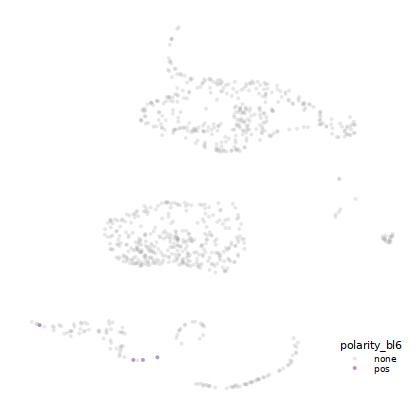

In [22]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_bl6_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_other 

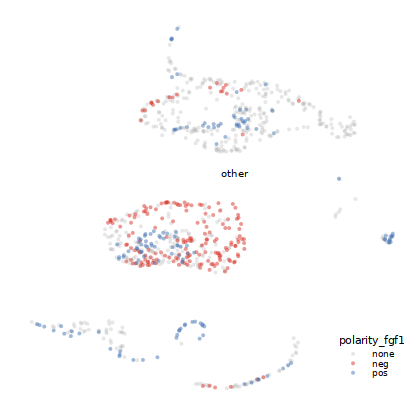

In [23]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
label_data <- da_results %>%
  filter(class == 'other') %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(1, "lines"), 
              point.padding = unit(2, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_other 

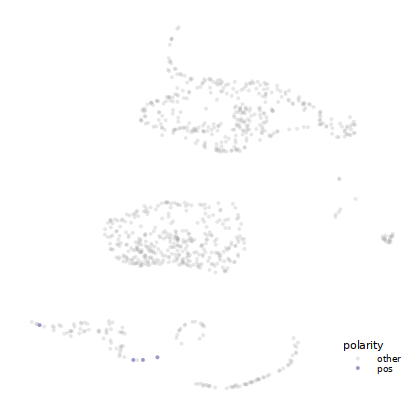

In [24]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_restored_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_other 

In [25]:
all_restored_summary = qs::qread('_targets/objects/all_restored_summary') %>%
filter(comparison == 'Day5.obob5v5__v__Day5.obobBL6d5') %>%
mutate(prop_fgf1 = n_fgf1/n_total) %>%
mutate(prop_BL6 = n_BL6/n_total) %>%
mutate(prop_sum = prop_fgf1 + prop_BL6) %>%
mutate(n_sum = n_fgf1 + n_BL6) %>%
arrange(desc(n_fgf1))

all_restored_summary %>% head

label_order = all_restored_summary %>% pull(labels)
label_order

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
other,855,325,139,186,0.4276923,4,4,4,0,1.0000000,0.01230769,Day5.obob5v5__v__Day5.obobBL6d5,0.3801170,0.004678363,0.3847953,329
Astrocytes,441,190,80,110,0.4210526,129,30,2,28,0.2325581,0.15789474,Day5.obob5v5__v__Day5.obobBL6d5,0.4308390,0.292517007,0.7233560,319
g2,424,182,75,107,0.4120879,94,24,1,23,0.2553191,0.13186813,Day5.obob5v5__v__Day5.obobBL6d5,0.4292453,0.221698113,0.6509434,276
n1,392,82,31,51,0.3780488,201,58,8,50,0.2885572,0.70731707,Day5.obob5v5__v__Day5.obobBL6d5,0.2091837,0.512755102,0.7219388,283
Htr3b,142,77,42,35,0.5454545,3,3,3,0,1.0000000,0.03896104,Day5.obob5v5__v__Day5.obobBL6d5,0.5422535,0.021126761,0.5633803,80
OPC,97,58,27,31,0.4655172,0,0,0,0,NaN,0.00000000,Day5.obob5v5__v__Day5.obobBL6d5,0.5979381,0.000000000,0.5979381,58


[1] "other"               "Astrocytes"          "g2"                 
 [4] "n1"                  "Htr3b"               "OPC"                
 [7] "g3"                  "Agrp"                "Trh__Lef1"          
[10] "Tanycytes"           "n0"                  "Oligodendrocytes"   
[13] "g1"                  "Ghrh"                "Ppp1r17__Tafa4"     
[16] "Ependymal_cells"     "Sst__Unc13c"         "Tbx19__Pirt"        
[19] "Irx5__Lmx1a"         "Kiss1__Tac2"         "Pomc__Glipr1"       
[22] "Pou6f2__Prkcq__Whrn" "Sst__Pthlh"          "n8"                 
[25] "Th__Slc6a3"          "neuron"              "Arx__Nr5a2"         
[28] "Dlk1"                "Endothelial_cells"   "Esr1"               
[31] "Fez1"                "Gpr50__Tac2"         "Hdc"                
[34] "Lepr15"              "Lepr67"              "Lepr89"             
[37] "Lpar1_oligo"         "Met__Pappa2"         "Met__Prlh"          
[40] "Microglia"           "Nfib_1"              "Nfib_2"             
[43] "Nfib_3"              "Nfix__Nfib"          "Nfix__Nfib__Hgf"    
[46] "Nfix__Nfib__Lhx6"    "Npsr1__Epha3"        "Pomc__Anxa2"        
[49] "Pomc__Ttr"           "Ppp1r17"             "Ppp1r17__Ltbp1"     
[52] "Reln__Lef1"          "Sim1"                "Slc17a6__Trhr"      
[55] "Sst__Nts"            "Th__Nfib"            "Tmem215__Dach2"     
[58] "Tmem215__Greb1"      "Trh__Cxcl12"         "g4"                 
[61] "g_drop"              "n2"                  "n3"                 
[64] "n4"                  "n5"                  "n6"                 
[67] "n_drop"

In [26]:
all_restored_summary %>% filter(prop_sum > 0) %>%
left_join(labels_classes_tib, by='labels') %>%
group_by(class) %>% summarise(n=n())

class,n
<chr>,<int>
neuron,1
other,1
NA,38


In [27]:
all_restored_summary %>%
left_join(labels_classes_tib, by='labels') %>%
filter(class=='neuron') %>%
arrange(desc(n_sum)) %>%
head(20)

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum,class
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
neuron,2830,1,1,NA,1,178,1,1,0,0.005617978,1,Day5.obob5v5__v__Day5.obobBL6d5,0.0003533569,0.06289753,0.06325088,179,neuron


In [28]:
unchanged_labels = all_restored_summary %>%
filter(!(prop_sum > 0)) %>%
pull(labels)
unchanged_labels

[1] "Dlk1"              "Endothelial_cells" "Esr1"             
 [4] "Fez1"              "Gpr50__Tac2"       "Hdc"              
 [7] "Lepr15"            "Lepr67"            "Lepr89"           
[10] "Met__Pappa2"       "Microglia"         "Nfib_1"           
[13] "Nfib_2"            "Nfib_3"            "Nfix__Nfib"       
[16] "Npsr1__Epha3"      "Ppp1r17"           "Ppp1r17__Ltbp1"   
[19] "Reln__Lef1"        "Sim1"              "Slc17a6__Trhr"    
[22] "Sst__Nts"          "g4"                "g_drop"           
[25] "n4"                "n6"                "n_drop"

In [29]:
all_restored_summary %>%
filter(str_detect(labels, 'Ghrh'))

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Ghrh,70,7,3,4,0.4285714,35,7,3,4,0.2,1,Day5.obob5v5__v__Day5.obobBL6d5,0.1,0.5,0.6,42


In [30]:
beeswarm_tibble = da_results %>%
select(Nhood, labels, class, n_cells, polarity_fgf1, SpatialFDR_fgf1, logFC_fgf1, polarity_bl6, SpatialFDR_bl6, logFC_bl6, exact_grouping) %>%
mutate(restored = case_when(exact_grouping == 'pos_restored' ~ 'yes',
                             exact_grouping == 'neg_restored' ~ 'yes',
                             TRUE ~ 'no')) %>%
mutate(restored = factor(restored, levels=c('no', 'yes')))

# Separate data frames for each type of measurement
polarity_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("polarity"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("polarity"),
               names_to = "comparison",
               values_to = "polarity") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

spatial_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("SpatialFDR"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("SpatialFDR"),
               names_to = "comparison",
               values_to = "SpatialFDR") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

logfc_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("logFC"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("logFC"),
               names_to = "comparison",
               values_to = "logFC") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

# Join all dataframes
beeswarm_tibble <- polarity_df %>%
  inner_join(spatial_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored")) %>%
  inner_join(logfc_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored"))


beeswarm_tibble = beeswarm_tibble %>%
mutate(labels = factor(labels, levels=rev(label_order))) %>%
rowwise %>%
mutate(label.group = paste0(labels, '.', comparison)) %>% 
ungroup %>%
mutate(polarity = paste0(polarity, '.', comparison)) %>%
mutate(polarity = case_when(str_detect(polarity, 'none') ~ 'none',
                            TRUE ~ polarity)) %>%
mutate(polarity = factor(polarity, levels=rev(c('none', 'neg.BL6', 'pos.BL6', 'neg.FGF1', 'pos.FGF1')))) %>%
arrange(desc(labels))

beeswarm_tibble

Nhood,labels,class,n_cells,exact_grouping,restored,comparison,polarity,SpatialFDR,logFC,label.group
<dbl>,<fct>,<chr>,<dbl>,<chr>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<chr>
386,other,other,80,pos_FGF1,no,FGF1,pos.FGF1,5.913861e-07,5.7880850,other.FGF1
386,other,other,80,pos_FGF1,no,BL6,none,9.587951e-01,0.3291051,other.BL6
822,other,other,70,pos_FGF1,no,FGF1,pos.FGF1,5.913861e-07,6.6390950,other.FGF1
822,other,other,70,pos_FGF1,no,BL6,none,7.890363e-01,1.3817936,other.BL6
464,other,other,72,pos_FGF1,no,FGF1,pos.FGF1,8.770765e-07,5.0318362,other.FGF1
464,other,other,72,pos_FGF1,no,BL6,none,9.607907e-01,-0.2793494,other.BL6
263,other,other,70,pos_FGF1,no,FGF1,pos.FGF1,1.180133e-06,4.9838278,other.FGF1
263,other,other,70,pos_FGF1,no,BL6,none,9.597985e-01,-0.2828503,other.BL6
199,other,other,65,pos_FGF1,no,FGF1,pos.FGF1,1.274122e-06,4.8487326,other.FGF1


In [31]:
beeswarm_tibble %>% head %>% print

# A tibble: 6 × 11
  Nhood labels class n_cells exact_grouping restored comparison polarity
  <dbl> <fct>  <chr>   <dbl> <chr>          <fct>    <chr>      <fct>   
1   386 other  other      80 pos_FGF1       no       FGF1       pos.FGF1
2   386 other  other      80 pos_FGF1       no       BL6        none    
3   822 other  other      70 pos_FGF1       no       FGF1       pos.FGF1
4   822 other  other      70 pos_FGF1       no       BL6        none    
5   464 other  other      72 pos_FGF1       no       FGF1       pos.FGF1
6   464 other  other      72 pos_FGF1       no       BL6        none    
# ℹ 3 more variables: SpatialFDR <dbl>, logFC <dbl>, label.group <chr>


In [32]:
beeswarm_tibble %>% pull(polarity) %>% unique
beeswarm_tibble %>% pull(polarity) %>% levels

[1] pos.FGF1 none     neg.FGF1 pos.BL6  neg.BL6 
Levels: pos.FGF1 neg.FGF1 pos.BL6 neg.BL6 none

[1] "pos.FGF1" "neg.FGF1" "pos.BL6"  "neg.BL6"  "none"

In [33]:
beeswarm_tibble %>% filter(restored == 'yes') %>% dim

[1] 10 11

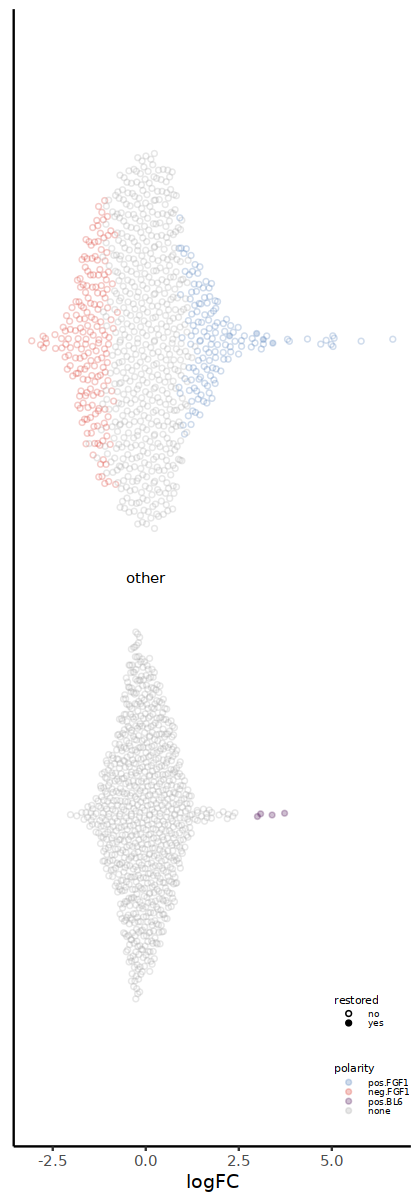

In [34]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- beeswarm_tibble %>%
  filter(class == 'other')  %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  distinct(labels)

beeswarm_other = beeswarm_tibble %>%
  filter(class == 'other') %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.9,0.08)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))
beeswarm_other

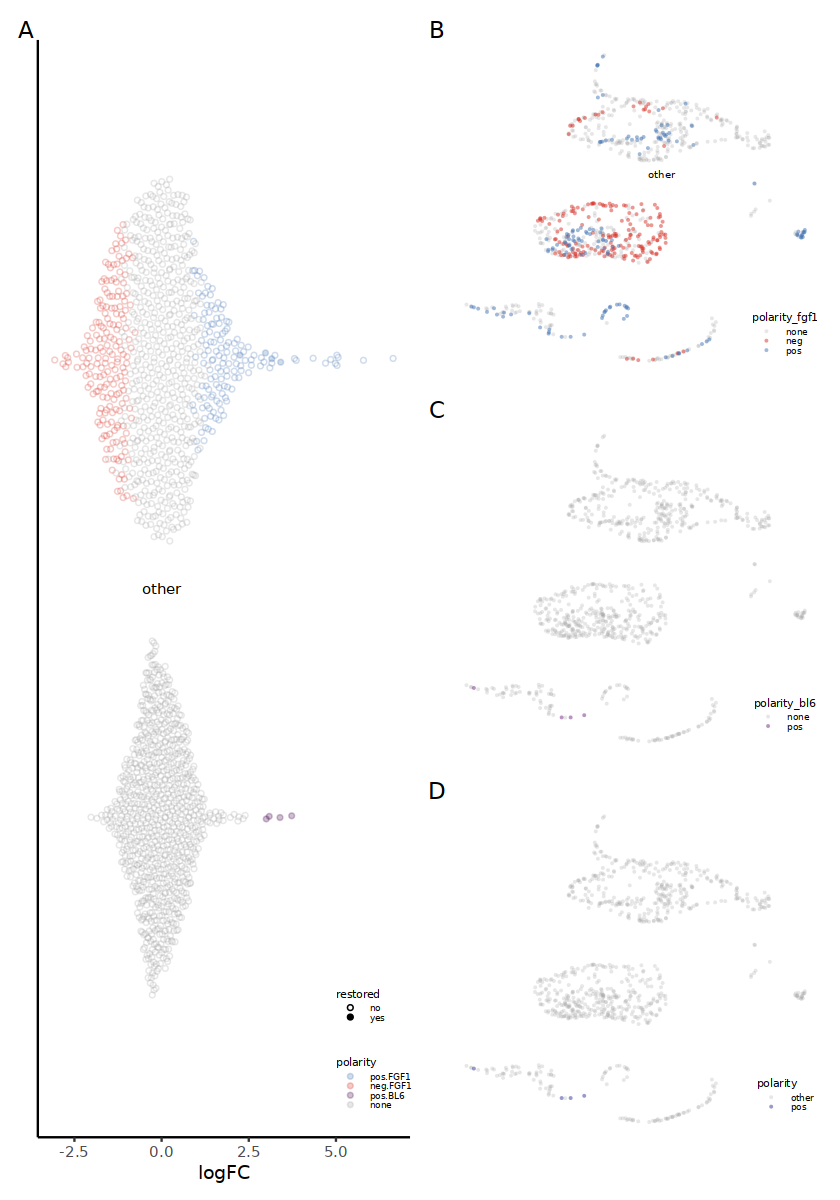

In [35]:
options(repr.plot.width=7, repr.plot.height=10)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_other,
           B = umap_fgf1_other,
           C = umap_bl6_other,
           D = umap_restored_other,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_other_d5_class.pdf', plot = ., width = 7, height=9)
ggp

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 0

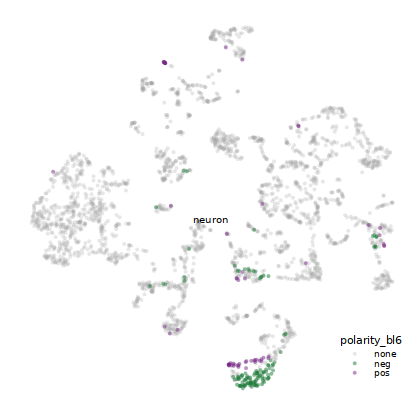

In [36]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_bl6 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_bl6 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_bl6 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_bl6_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_neuron

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 0

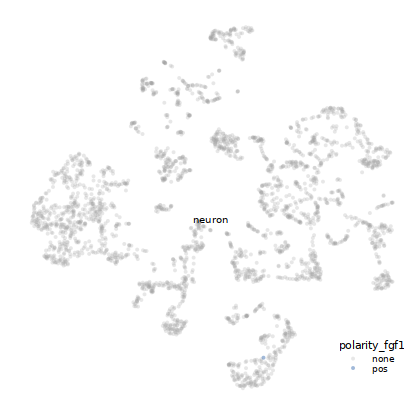

In [37]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_fgf1 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_fgf1 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_fgf1 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_neuron 

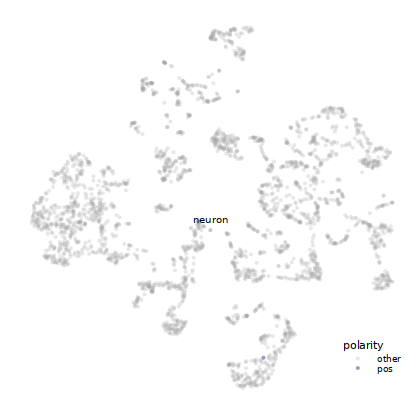

In [38]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_restored_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_neuron 

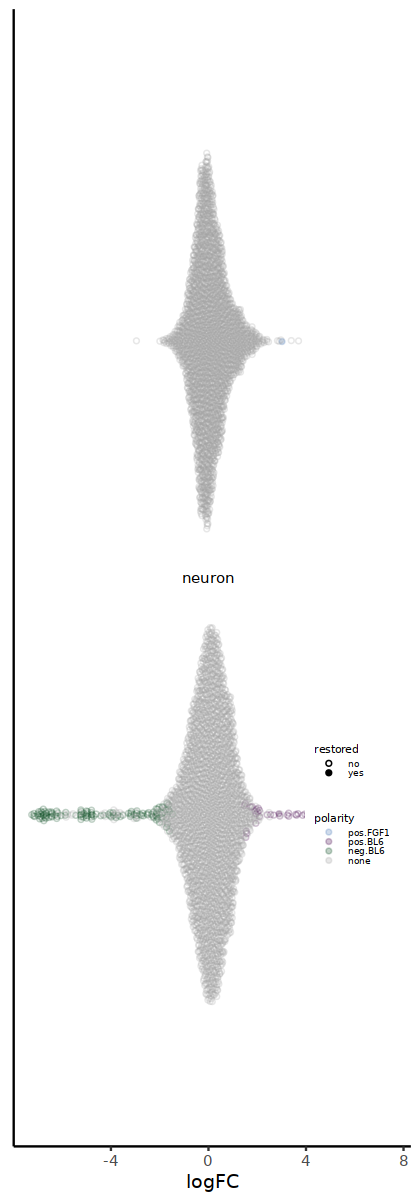

In [39]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- da_results %>%
  filter(class == 'neuron') %>%
  filter((polarity_fgf1 %in% c('pos', 'neg')) | (polarity_bl6 %in% c('pos', 'neg'))) %>%
  distinct(labels)

beeswarm_neuron = beeswarm_tibble %>%
  filter(class == 'neuron') %>%
  filter((labels %in% label_tibble$labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.85,0.3)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

beeswarm_neuron

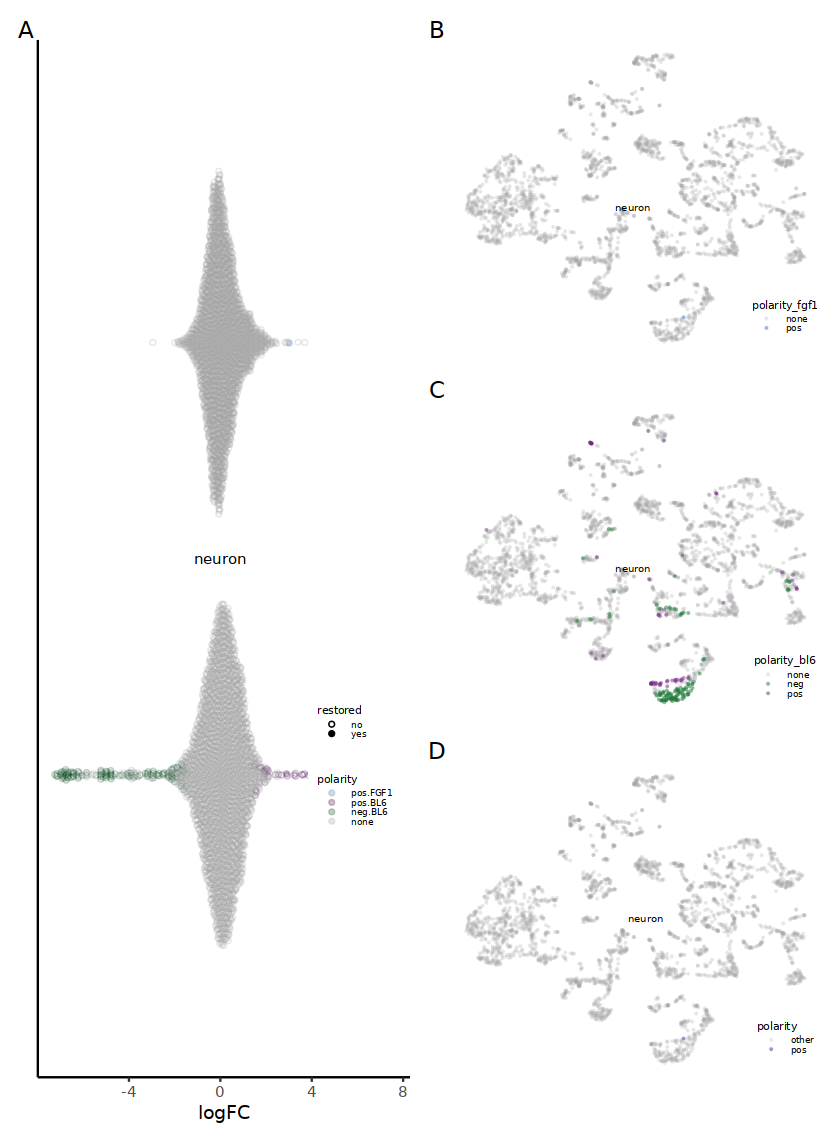

In [40]:
options(repr.plot.width=7, repr.plot.height=9.5)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_neuron,
           B = umap_fgf1_neuron,
           C = umap_bl6_neuron,
           D = umap_restored_neuron,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_neurons_d5_class.pdf', plot = ., width = 7, height=9)
ggp

In [41]:
beeswarm_tibble %>% qs::qsave('beeswarm_tibble_d5.qs')
da_results %>% qs::qsave('beeswarm_da_results_d5.qs')